In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

c:\Users\HP\anaconda3\envs\env1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import glob

csv_files = glob.glob('archive/ieee-phm-2012-data-challenge-dataset-master/Learning_set/Bearing1_2/acc*.csv')



In [2]:
dataset = pd.read_csv('bearing1_2.csv')

In [3]:
dataset

,hour,minute,second,micro,ax,ay
0,8,47,5,196950.0,0.165,-0.140
1,8,47,5,196990.0,0.125,0.542
2,8,47,5,197030.0,0.157,-0.261
3,8,47,5,197070.0,0.421,0.081
4,8,47,5,197110.0,0.683,-0.278
...,...,...,...,...,...,...
2228884,11,12,5,296720.0,-2.595,3.622
2228885,11,12,5,296760.0,-2.869,8.675
2228886,11,12,5,296800.0,1.457,8.111
2228887,11,12,5,296840.0,1.591,1.403


In [4]:
dataset.head()

,hour,minute,second,micro,ax,ay
0,8,47,5,196950.0,0.165,-0.140
1,8,47,5,196990.0,0.125,0.542
2,8,47,5,197030.0,0.157,-0.261
3,8,47,5,197070.0,0.421,0.081
4,8,47,5,197110.0,0.683,-0.278


In [5]:
dataset['timestamp'] = pd.to_datetime({'year': 2024, 'month': 1, 'day': 13, 'hour': dataset['hour'], 'minute': dataset['minute'], 'second': dataset['second'], 'microsecond': dataset['micro']})


In [6]:
dataset = dataset.drop(columns=["hour", "minute", "second", "micro"])

In [7]:
# change order of columns
cols = ["timestamp", "ax", "ay"]
dataset = dataset[cols]

In [8]:
dataset.head()

,timestamp,ax,ay
0,2024-01-13 08:47:05.196950,0.165,-0.140
1,2024-01-13 08:47:05.196990,0.125,0.542
2,2024-01-13 08:47:05.197030,0.157,-0.261
3,2024-01-13 08:47:05.197070,0.421,0.081
4,2024-01-13 08:47:05.197110,0.683,-0.278


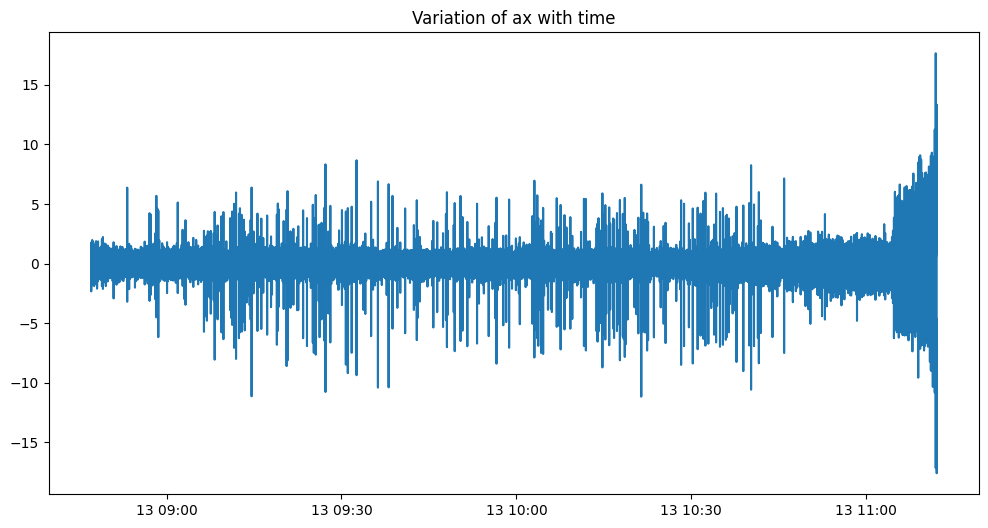

In [10]:
#now we will check variation of the data with time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dataset['timestamp'], dataset['ax'])
plt.title('Variation of ax with time')
plt.show()


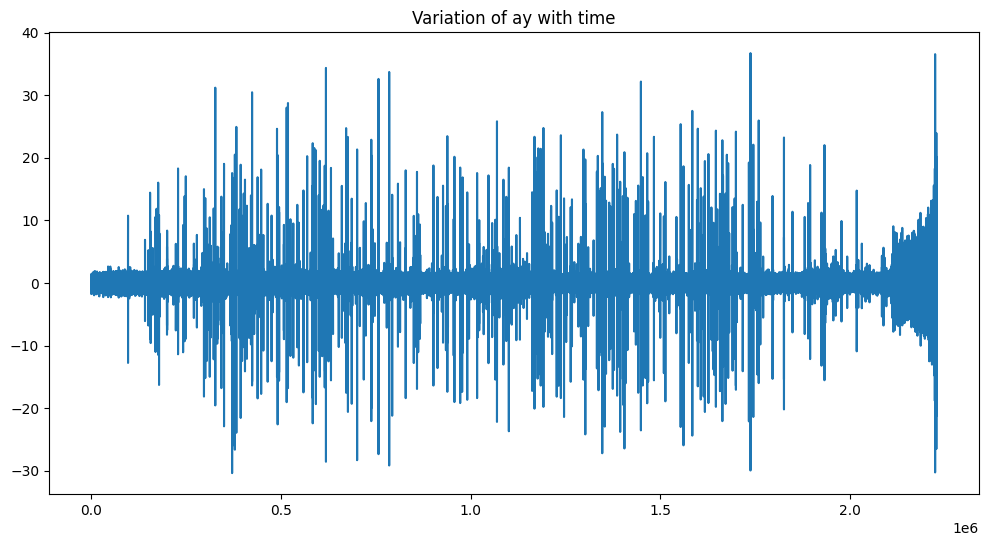

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dataset['index'], dataset['ay'])
plt.title('Variation of ay with time')
plt.show()

In [9]:
#now we add a column for index
dataset['index'] = range(0, len(dataset))


In [10]:
dataset.tail()

,timestamp,ax,ay,index
2228884,2024-01-13 11:12:05.296720,-2.595,3.622,2228884
2228885,2024-01-13 11:12:05.296760,-2.869,8.675,2228885
2228886,2024-01-13 11:12:05.296800,1.457,8.111,2228886
2228887,2024-01-13 11:12:05.296840,1.591,1.403,2228887
2228888,2024-01-13 11:12:05.296870,-4.701,-0.508,2228888


In [11]:
X = dataset["ax"]
Y = dataset["index"]

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)

In [27]:
from torch.utils.data import DataLoader, TensorDataset
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, X_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, X_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

KeyError: 10

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=256, nhead=4, num_layers=8, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
from sklearn.metrics import r2_score

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"RMSE for {col}: {rmse:.4f}")

r2 = r2_score(scaler.inverse_transform(y_test.numpy().reshape(-1, 1)), scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
print(f"R2 Score for {col}: {r2:.4f}")
scores.append([col, rmse, r2])